In [2]:
import numpy as np
import density_field_library as DFL
import config as conf
import matplotlib.pyplot as plt
from math import pi
import Pk_library as PKL
import config as conf
import my_remote_spectra as remote_spectra
import importlib
import estim
from estim import estimator
import redshifts

In [3]:
importlib.reload(conf)
importlib.reload(estim)
zb = redshifts.binning(conf_module = conf) 
Omega_b = conf.Omega_b
Omega_c = conf.Omega_c
w = conf.w
wa = conf.wa
Omega_K = conf.Omega_K
h = conf.h
zbins_acentral = 1/(1+zb.zbins_zcentral)
Dv_central = -remote_spectra.Dv_inter(Omega_b, Omega_c, w, wa, Omega_K, h)(zbins_acentral)

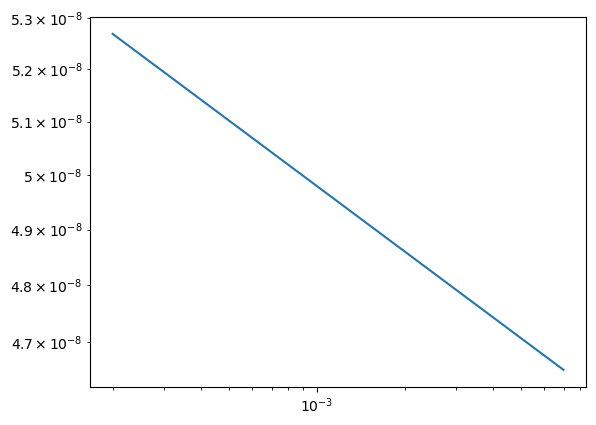

In [132]:
As= conf.As
ns = conf.ns
k_in = np.linspace(2e-4, 7e-3, 100)
k_pivot = 0.05
Pk_in = 2*pi**2*As*(k_in/k_pivot)**(ns-1)*1e-9
# P_psi = remote_spectra.Ppsi(k_test, As, ns)
if 1:
    plt.plot(k_in, Pk_in)
    plt.xscale('log')
    plt.yscale('log')

In [133]:
grid              = 64  #grid size
BoxSize           = 30000.0 #Mpc/h
seed              = 1      #value of the initial random seed
Rayleigh_sampling = 0      #whether sampling the Rayleigh distribution for modes amplitudes
threads           = 1      #number of openmp threads
verbose           = True   #whether to print some information

# read power spectrum; k and Pk have to be floats, not doubles
# k, Pk = np.loadtxt('my_Pk.txt', unpack=True)

k_in, Pk_in = k_in.astype(np.float32), Pk_in.astype(np.float32)
# generate a 2D Gaussian density field
# df_2D = DFL.gaussian_field_2D(grid, k, Pk, Rayleigh_sampling, seed,
                              # BoxSize, threads, verbose)
# Pk_in = Pk_in/k_in**3

# generate a 3D Gaussian density field
psi_x = DFL.gaussian_field_3D(grid, k_in, Pk_in, Rayleigh_sampling, seed,
                              BoxSize, threads, verbose)

delta(k) field generated
time taken = 0.01734 seconds



In [134]:
# test the "variance" paper setup
if 1:
    L = 313000
    Resolution = 128
    Lambda_min = 484
    k_max = 1/2*2*pi/(L/Resolution)
    print(k_max)
    print(1/2*2*pi/Lambda_min)
    print(2*pi/Lambda_min)

0.001284740765685283
0.006490893912375606
0.012981787824751212


In [135]:
Pk = PKL.Pk(psi_x, BoxSize)
# 1D P(k)
k1D      = Pk.k1D
Pk1D     = Pk.Pk1D
Nmodes1D = Pk.Nmodes1D

# 2D P(k)
kpar     = Pk.kpar
kper     = Pk.kper
Pk2D     = Pk.Pk2D
Nmodes2D = Pk.Nmodes2D

# 3D P(k)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0] #monopole
Pk2     = Pk.Pk[:,1] #quadrupole
Pk4     = Pk.Pk[:,2] #hexadecapole
Pkphase = Pk.Pkphase #power spectrum of the phases
Nmodes  = Pk.Nmodes3D


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


In [137]:
kF,kN,kmax_par,kmax_per,kmax = PKL.frequencies(BoxSize, grid)
print(kF)
print(kN)

0.00020943951023931953
0.006702064327658225


In [138]:
d = BoxSize/grid
SampleRate = 1/d
Max_k = 1/2*2*pi*SampleRate
Min_k = 2*pi/BoxSize
print(Min_k)
print(Max_k)

0.00020943951023931953
0.006702064327658226


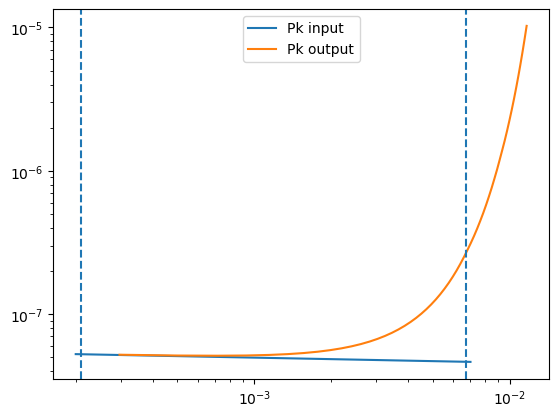

In [140]:
plt.plot(k_in, Pk_in, label='Pk input')
# plt.plot(k[:20], Pk0[:20], label='Pk output')
plt.plot(k, Pk0, label='Pk output')

plt.xscale('log')
plt.yscale('log')
plt.axvline(x=Max_k, linestyle = '--')
plt.axvline(x=Min_k, linestyle = '--')
plt.legend()

In [141]:
# 3-d real space axes
d = BoxSize/grid
x = np.arange(-BoxSize/2, BoxSize/2, d)
y = np.arange(-BoxSize/2, BoxSize/2, d)
z = np.arange(-BoxSize/2, BoxSize/2, d)
# 3-d meshgrid coordinate
# xx, yy = np.meshgrid(x, y)
xx, yy, zz = np.meshgrid(x, y, z)
rr = np.sqrt(xx**2 + yy**2 + zz**2)
print(xx.shape)

(64, 64, 64)


In [142]:
if 0:
    k_x = np.fft.fftfreq(grid, d)
    k_y = np.fft.fftfreq(grid, d)
    k_z = np.fft.fftfreq(grid, d)
    kk_x, kk_y, kk_z = np.meshgrid(k_x, k_y, k_z)
    kk_x_s, kk_y_s, kk_z_s = np.fft.fftshift(kk_x), np.fft.fftshift(kk_y), np.fft.fftshift(kk_z)
    
    kk  = np.sqrt(kk_x_s**2 + kk_y_s**2 + kk_z_s**2)
    kk.shape

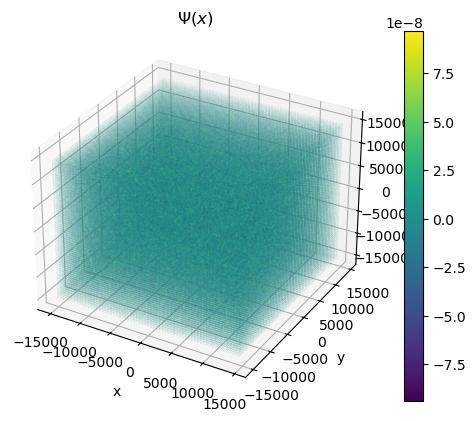

In [143]:
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.colorbar(ax.scatter(xx,yy,zz,c=psi_x, s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\Psi (x)$');

In [144]:
a = 0.8
D_psi = remote_spectra.Dpsi_inter(Omega_b, Omega_c, w, wa, Omega_K, h)(a)
psi_x_a = D_psi*psi_x

In [145]:
Pk_a = PKL.Pk(psi_x_a, BoxSize)
# 3D P(k)
k_a  = Pk_a.k3D
Pk0_a = Pk_a.Pk[:,0]


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds


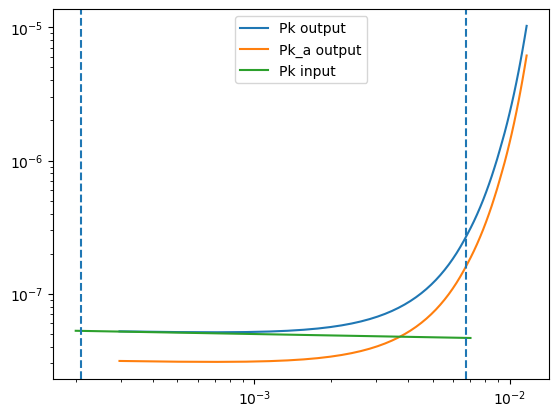

In [146]:
# plt.plot(k_in[2:400], Pk_in[2:400], label='Pk input')
plt.plot(k, Pk0, label='Pk output')
plt.plot(k_a, Pk0_a, label='Pk_a output')
plt.plot(k_in, Pk_in, label='Pk input')
plt.axvline(x=Max_k, linestyle = '--')
plt.axvline(x=Min_k, linestyle = '--')

plt.xscale('log')
plt.yscale('log')
plt.legend()

In [147]:
# Now let's add the inhomogeneous potential psi_i_x where i for inhomogeneous
import param
A = param.A
B = param.B
x_c = param.x_c
r_H = param.r_H
print(A)
print(B)
print(x_c)
print(r_H)

0.0001
0.0
0
4411.764705882353


In [148]:
x_xc = np.concatenate((np.zeros(int((BoxSize/2+x_c)/d)), np.arange(0, BoxSize/2-x_c, d)))
xx_xc, _, _ = np.meshgrid(x_xc, y, z)
psi_i_x = A*(xx_xc/r_H) + B*(xx_xc/r_H)**2
g_psi_i = np.gradient(psi_i)

In [ ]:
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.colorbar(ax.scatter(xx,yy,zz,c=psi_i_x, s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\Psi_{i} (x)$');

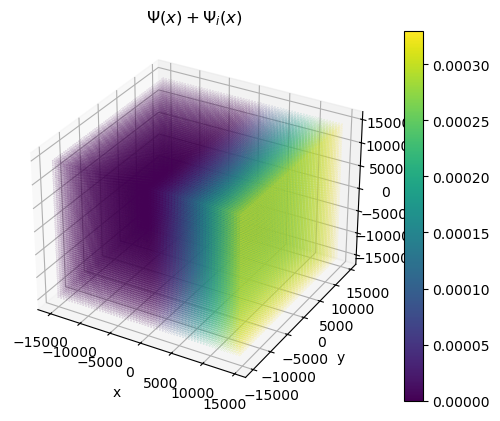

In [107]:
if 1:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.colorbar(ax.scatter(xx,yy,zz,c=psi_x+psi_i_x, s=0.01))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\Psi (x) + \Psi_{i} (x)$');

In [ ]:
# why psi_i_x is so much larger than psi_x?